# Chatbot con voz

Iniciamos importando las librerías requeridas para este proyecto

In [17]:
import speech_recognition as sr

import json

import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import cess_esp
from nltk.tag.hmm import HiddenMarkovModelTagger

from nltk.chunk.regexp import *

from urllib.request import Request, urlopen

import requests, pyttsx3

from deep_translator import GoogleTranslator


In [18]:
openAIKEY = ""

In [19]:
traductor_es = GoogleTranslator(source='en', target='es')
traductor_en = GoogleTranslator(source='es', target='en')

In [20]:
hmm = HiddenMarkovModelTagger.train(cess_esp.tagged_sents())

In [21]:
def tokenizar(_frase):
    return word_tokenize(_frase)

def taggear(_tokens):
    return hmm.tag(_tokens)

In [22]:
taggear(tokenizar('Quiero saber el resultado del Barcelona contra Betis'))

[('Quiero', 'sps00'),
 ('saber', 'vmn0000'),
 ('el', 'da0ms0'),
 ('resultado', 'ncms000'),
 ('del', 'spcms'),
 ('Barcelona', 'np0000l'),
 ('contra', 'sps00'),
 ('Betis', 'np0000o')]

In [23]:
reglas = """
Equipo: { <np.*> }
Equipo: { <da.* | np.* > <np.*> }
Partido: { <Equipo>  <sp.*> <Equipo> }
"""
parser = nltk.RegexpParser(reglas)


In [24]:
corpus_fix = [
    [('Manchester United', 'NP00000'), ('Real Madrid', 'NP00000')]
]

hmm.train(corpus_fix)

<HiddenMarkovModelTagger 1 states and 2 output symbols>

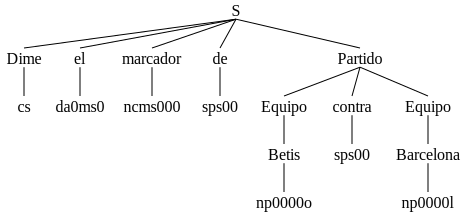

In [25]:
parser.parse(taggear(tokenizar('Dime el marcador de Betis contra Barcelona')))

In [26]:
def obtener_Info(_tree):
    result = []

    for nodo in _tree:
        if(type(nodo) != tuple):
            if(nodo.label() == 'Partido'):
                partido = ''
                for elemento in nodo:
                    if(type(elemento) != tuple):
                        if(elemento.label() == 'Equipo'):
                            partido += ' '.join([ hoja[0] for hoja in elemento.leaves()]) + ' '
    return partido.strip().replace(' ', '_vs_')


In [27]:
frase = parser.parse(taggear(tokenizar('Dime el marcador de Juventus contra Inter')))

In [28]:
def obtener_Marcador(_frase):
    url = 'https://www.thesportsdb.com/api/v1/json/3/searchevents.php?e=' + obtener_Info(frase)    
    data = requests.get(url)
    evento = json.loads(data.text)
    return f"El resultado del último encuentro de {evento['event'][0]['strHomeTeam']} y {evento['event'][0]['strAwayTeam']} fue de {evento['event'][0]['intHomeScore']} a {evento['event'][0]['intAwayScore']}"

In [29]:
def listen():
    mic = sr.Microphone()
    with mic as source:
        instance = sr.Recognizer()
        audio = instance.listen(source)
        transcript = instance.recognize_google(audio, language='es-ES', show_all=True)
        
        return transcript['alternative'][0]['transcript']

In [30]:
engine = pyttsx3.init()
def speak(_text, _voice = 0):
    voices = engine.getProperty('voices')
    engine.setProperty('voice', voices[_voice].id)
    engine.setProperty('rate', 130)
    engine.say(_text)
    engine.runAndWait()

In [40]:
frase = parser.parse(taggear(tokenizar(listen())))
resultado = obtener_Marcador(obtener_Info(frase))
print(resultado)
speak(resultado, 1)

El resultado del último encuentro de Juventus y Inter fue de 1 a 1
